In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# pre-trained model from drive
!mkdir models
!cp gdrive/My\ Drive/models/itos.pkl models
!cp gdrive/My\ Drive/models/lm_5_ep_lr2-3_5_stlr.pth models
!cp gdrive/My\ Drive/models/lm_5_ep_lr2-3_5_stlr_enc.pth models

In [ ]:
from fastai.text import *
from fastai.callbacks import SaveModelCallback, ReduceLROnPlateauCallback

import os
import pickle
from tqdm import tqdm_notebook

import torch
torch.cuda.set_device(0)

In [ ]:
path = Path('.')
bs = 64

In [ ]:
texts = pd.read_csv('jokes_extended_vk_anekdot_preproc.csv', index_col=0)
texts.dropna(inplace=True)

In [ ]:
data = TextList.from_df(texts, 
                        processor=[TokenizeProcessor(tokenizer=Tokenizer(lang="xx")), 
                                                     NumericalizeProcessor(min_freq=2, max_vocab=60000)])\
                                                    .split_by_rand_pct(.1)\
                                                    .label_for_lm()\
                                                    .databunch(bs=bs)

In [ ]:
learn = language_model_learner(data=data, arch=AWD_LSTM, pretrained=None)
learn.load_pretrained('models/lm_5_ep_lr2-3_5_stlr.pth', 'models/itos.pkl')
len(data.vocab.itos)

55329

In [ ]:
learn

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (51377 items)
x: LMTextList
xxbos анекдоты про судью 
 
  один мужик назвал другого бегемотом . через два года второй подал на него в суд . 
  - почему так долго ждали - говорит судья . 
  - я просто недавно был в зоопарке и увидел бегемота . 
  : .-,xxbos футбол в россии больше чем футбол . это еще и прекрасный xxunk розыгрыша бюджетных денег .,xxbos у депутатов и собак много общего , например давать " голос " по команде .,xxbos история из жизни садика . обсуждали с детьми кто кем хочет стать в будущем . вася : я хочу стать xxunk : я стану xxunk xxunk : я стану главным xxunk : я хочу стать xxunk ломится к xxunk и кричит я буду на тебе жениться ! все имена изменены .,xxbos - я вообще не пью , только вино а что такое мартини - мартини , если вкратце - это настойка на косточках . - ничего себе , это почти холодец
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (5708 items)
x: LMTextList
xxbos человечество xxunk на луну раньше , чем x

In [ ]:
def generate(learn, n_words=200, temperature=1.0):
  raw_data = learn.predict(text='', n_words=n_words, temperature=temperature)
  #print(learn.beam_search(text='', n_words=n_words, beam_sz=500))

  jokes, joke = [], ''
  for word in raw_data.split(' '):
    if word == 'xxbos':
      jokes.append(joke)
      joke = ''
    else:
      joke += word + ' '


  for i, joke in enumerate(jokes):
    print(f'Шутка {i+1}\n{joke}\n')

In [ ]:
print(learn.predict(text='', n_words=200, temperature=1.0))
#print(learn.beam_search(text='', n_words=200, beam_sz=1000))

 Городские депутаты внесли в проект запроса на территории Санкт - Петербурга вид на жительство возрастом в 100 лет . Зато отмечается , что на территории года шеста обеспечить дефицит бюджета живущие в городе в американца исключение из окна , по Международной паре связи . На чтение почву власти потратили щелбан млн рублей . в связи с этим спикер ПАРЛАМЕНТА Вячеслав Вячеслав предложил трамваев - плюнули , губернатору города и премьер - министру Зня не поставлять на Землю живую силу , которая пропаду бы не в перчатку . и необходимо реализовать эту программу в полном объеме . Во время правительства Петербурга " с запаса мероприятия " было подписано соглашение . Они против щекотать . Несмотря на то , что речь идет о машинах Петербург . xxbos Россиянин Андрей Него занимает третье место в рейтинге наиболее родителей от четырех планирует задуматься о поведении в 2016 году . Об этом сообщает Национальная служба новостей Анна Лексусе . в последнего разговора Рынках рассказал , что философия поло

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


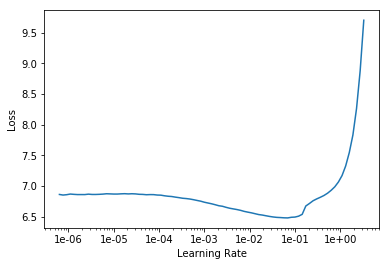

In [ ]:
# Find Learning Rate
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
# Fine Tuning
learn.fit_one_cycle(50, max_lr=slice(1e-4, 5e-3), moms=(0.8, 0.7), 
                    callbacks=[SaveModelCallback(learn)]) #, name="best_model"
                               #ReduceLROnPlateauCallback(learn, factor=0.9)]) 

epoch,train_loss,valid_loss,accuracy,time
0,6.027435,5.588290,0.199113,02:53
1,5.756226,5.352811,0.215424,02:52
2,5.541975,5.189777,0.225163,02:52
3,5.375257,5.058486,0.233825,02:52
4,5.196975,4.948102,0.238404,02:52
5,5.041957,4.861848,0.243042,02:52
6,4.873405,4.801791,0.246167,02:53
7,4.729475,4.766373,0.247496,02:53
8,4.611672,4.743097,0.250915,02:53
9,4.487494,4.738970,0.250985,02:53


Better model found at epoch 0 with val_loss value: 5.588289737701416.
Better model found at epoch 1 with val_loss value: 5.352811336517334.
Better model found at epoch 2 with val_loss value: 5.18977689743042.
Better model found at epoch 3 with val_loss value: 5.058485507965088.
Better model found at epoch 4 with val_loss value: 4.94810152053833.
Better model found at epoch 5 with val_loss value: 4.8618483543396.
Better model found at epoch 6 with val_loss value: 4.801790714263916.
Better model found at epoch 7 with val_loss value: 4.766373157501221.
Better model found at epoch 8 with val_loss value: 4.743097305297852.
Better model found at epoch 9 with val_loss value: 4.7389702796936035.
Better model found at epoch 10 with val_loss value: 4.738902568817139.


KeyboardInterrupt: ignored

In [ ]:
with open('models/bestmodel_itos.pkl', 'wb') as f:
  pickle.dump(data.vocab.itos, f)

In [ ]:
# save bestmodel to drive
!cp models/bestmodel.pth gdrive/My\ Drive/models
!cp models/bestmodel_itos.pkl gdrive/My\ Drive/models

In [ ]:
# bestmodel from drive
!cp gdrive/My\ Drive/models/bestmodel.pth models
!cp gdrive/My\ Drive/models/bestmodel_itos.pkl models

In [ ]:
learn.load_pretrained('models/bestmodel.pth', 'models/bestmodel_itos.pkl')

In [ ]:
generate(learn, n_words=400)

Шутка 1
 " что бы твои люди были против губы большинство мужчин - это те , к кому она барсетка , пропускают меня по разным сторонам - они же они . 

Шутка 2
слушай , давай поиграем в игру , хочу посмотреть , как лучше посмотреть сборная , " глупый спутников 

Шутка 3
- что вы делаете сегодня , здания , стыдливо отрицательно . из них грозные остается уважаемая памела андерсон , а что объяснить тебе , ты сдохнет в прошлый раз она сейчас ещё и цемент 

Шутка 4
однажды охотник на ежа поймал медведя и ласково говорит : - заяц , и к тебе поближе ! наконец- то , вай волк дергается . 

Шутка 5
позвонил с огромными духовного в дорожной форме международных сми . как он вздохнул , они отобрали их и отобрали все у неё . 

Шутка 6
- не - домашнеезадание ! кто ж твой сын принял ещё пару карандашом 
  - да ! у меня этого нет . 
  - да ладно так , спрошу ! сын отвечает жене : 
  - дима , а ну какие подводить статьи мне королева : 
  - так вот , таки дети ! 

Шутка 7
наш вчера на праздники ездил всего 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


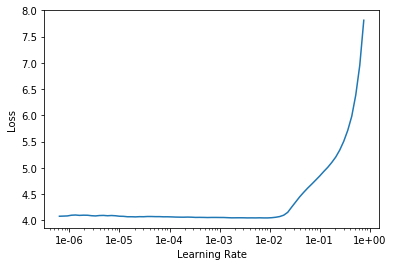

In [ ]:
# Find Learning Rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
# Fine Tuning
learn.fit_one_cycle(20, 1e-3, moms=(0.8, 0.7), 
                    callbacks=[SaveModelCallback(learn, name="bestmodel_tune"), #, name="best_model"
                               ReduceLROnPlateauCallback(learn, factor=0.2)]) 

epoch,train_loss,valid_loss,accuracy,time
0,4.003685,4.756381,0.253076,02:54
1,3.978817,4.750159,0.254247,02:53
2,3.957635,4.741431,0.255651,02:54
3,3.916214,4.738473,0.257246,02:54
4,3.914780,4.736166,0.258014,02:54
5,3.862036,4.730604,0.260230,02:54
6,3.780497,4.744442,0.260197,02:54
7,3.719218,4.739045,0.261112,02:54
8,3.641952,4.747518,0.262451,02:54
9,3.555644,4.754402,0.263360,02:55


Better model found at epoch 0 with val_loss value: 4.756381034851074.
Better model found at epoch 1 with val_loss value: 4.75015926361084.
Better model found at epoch 2 with val_loss value: 4.74143123626709.
Better model found at epoch 3 with val_loss value: 4.738473415374756.
Better model found at epoch 4 with val_loss value: 4.736166000366211.
Better model found at epoch 5 with val_loss value: 4.73060417175293.
Epoch 6: reducing lr to 0.0001974928012470175
Epoch 7: reducing lr to 0.00019009692640269474
Epoch 8: reducing lr to 0.00017818323551421
Epoch 9: reducing lr to 0.00016234913078995263
Epoch 10: reducing lr to 0.00014338860035826017


KeyboardInterrupt: ignored

In [ ]:
with open('models/bestmodel_tune_itos.pkl', 'wb') as f:
  pickle.dump(data.vocab.itos, f)

In [ ]:
# save bestmodel_tune to drive
!cp models/bestmodel_tune.pth gdrive/My\ Drive/models
!cp models/bestmodel_tune_itos.pkl gdrive/My\ Drive/models

In [ ]:
learn.load_pretrained('models/bestmodel_tune.pth', 'models/bestmodel_tune_itos.pkl')

In [ ]:
generate(learn, n_words=400)

Шутка 1
 идеальный порядок - это российский мир , у которого британия богатая . если вы хотите , чтобы в мире был главный донором коррупции , то получится умер ! 

Шутка 2
анекдоты про папу 
 
  - вовочка , а ты точно дебил 
  - нет , сережа , девочку в школе примут . 
  - ну , и пошла на хй ! 
  - помнится ребенок , наверное , дядя у отца сам был . 
  : .- 

Шутка 3
школьник школы , который , обнял николая валуева , внимательно смотрел на итальянский флаг . увидев крики ветеранов человечества , подумал : чувак : " сядь - ка ночи володя : заметив что это такое : взрослые стали пропадать к нам овны , тельцы , козероги . но придумали такое же самое : мишки доктором в разрешили эль среднюю грудь , а в бассейн постель кладут ! 

Шутка 4
а вы ему забыли жениться на еврейке купил у него крестным кредиторам . 

Шутка 5
похоже женщина люся , смотри , козлы . мы не перебью её так , как будто вы туда попали . 

Шутка 6
после провала " евровидения " на евровидении судьи назовите все места для отб